# Modelo C

Autor: Andres Cordero

# Setup del cuaderno

In [163]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import pandas as pd
import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import numpy as np
import inflect
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arisc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Entendimiento de los datos

In [138]:
df_original = pd.read_csv(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\ODScat_345.csv', encoding='utf-8')
df_test_original = pd.read_excel(r'C:\Users\arisc\Trabajos\Universidad\10 Semestre\BI\BI_PROY1_2402\Proyecto 1\Etapa 1\Datasets\TestODScat_345.xlsx')
df_original.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


In [139]:
train = df_original.copy()
train.head()

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


## Calidad de los datos

Dimensiones de calidad de los datos:
+ Consistencia
+ Validez
+ Completitud
+ Unicidad

### Completitud

Bajo una inspección sencilla, parece no haber problemas de completitud en los datos

In [140]:
train['sdg'].value_counts()

sdg
5    1451
4    1354
3    1244
Name: count, dtype: int64

In [141]:
# strip all values in the column
train['Textos_espanol'] = train['Textos_espanol'].str.strip()

# count all values in the column where the value is an empty string
train['Textos_espanol'].isnull().sum()

0

### Validez

Se identifican los siguietnes problemas de validez:
+ Hay un problema de codificación de los textos en el dataset, pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [142]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Textos_espanol'] = train['Textos_espanol'].apply(fix_encoding)

In [143]:
train.head(5)

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3


### Consistencia

Algunas de las entradas de texto del dataset están rodeadas por comillas dobles, aunque no todas. Es posible que esto no introduzca problemas en el dataset. 

### Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece no haber filas totalmente duplicadas.

In [144]:
train.duplicated().sum()

0

## Perfilamiento de los datos

Se aprovecha el paquete ydata-profiling para hacer un perfilamiento detallado del dataset. A partir de este reporte se destacan las siguientes conclusiones:
+ Variables: 2
+ Observaciones: 4049

|Variable|Tipo|
|--|--|
|Textos_espanol|Text|
|sdg|Categórica|

+ Se observa con ayuda del wordcloud que las palabras mas frecuentes en el dataset son stopwords que podrían ser eliminadas en el paso de procesamiento de datos. 


In [145]:
profile = ProfileReport(train, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [146]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

---------- Words for class: 3 ----------


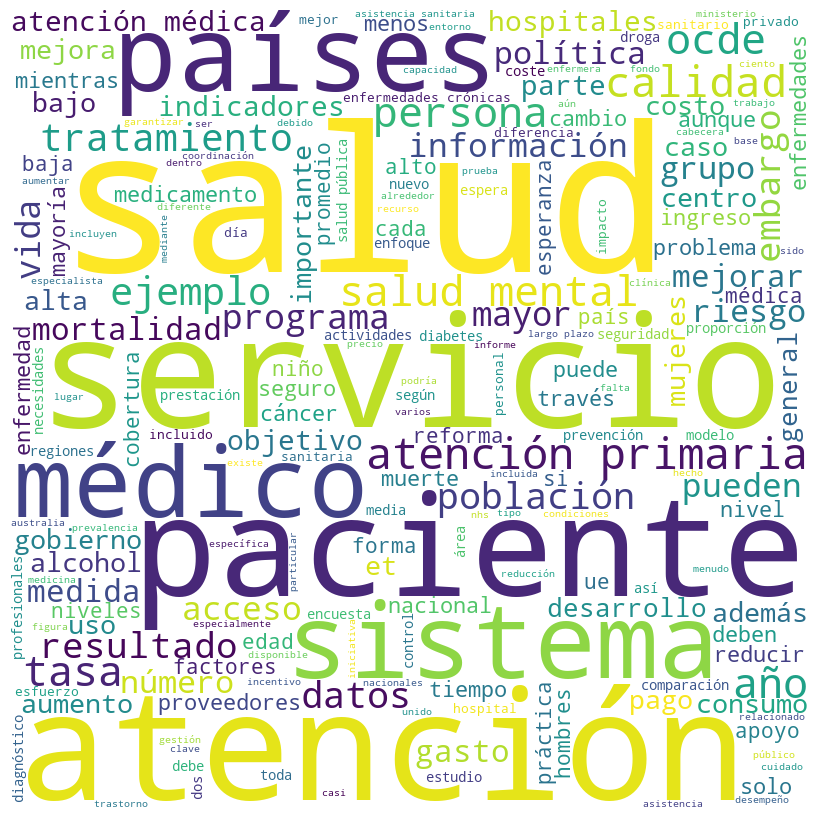

---------- Words for class: 4 ----------


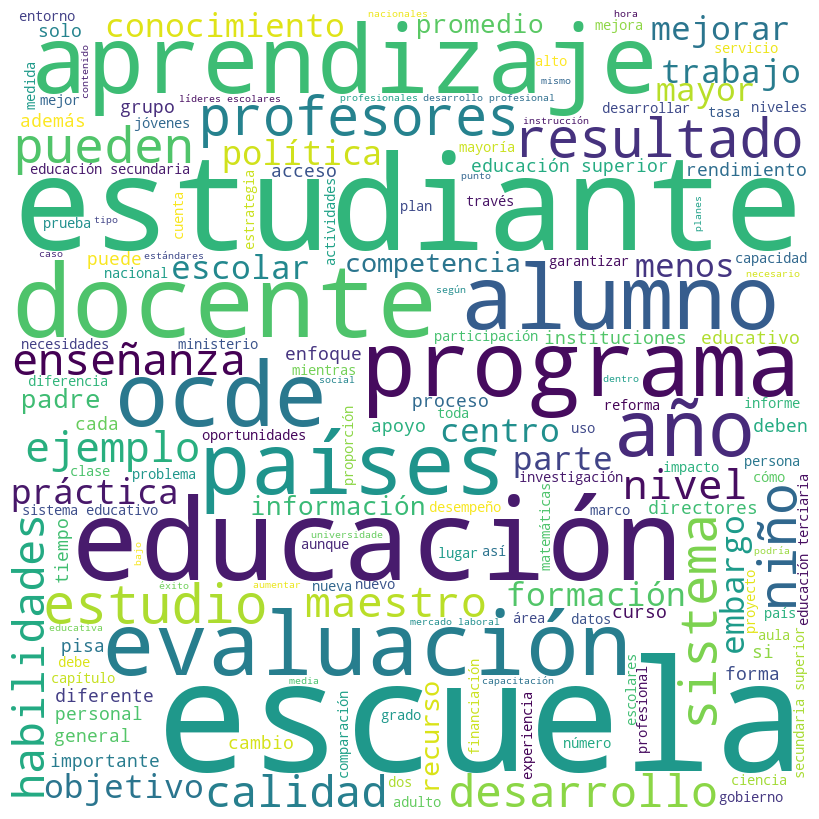

---------- Words for class: 5 ----------


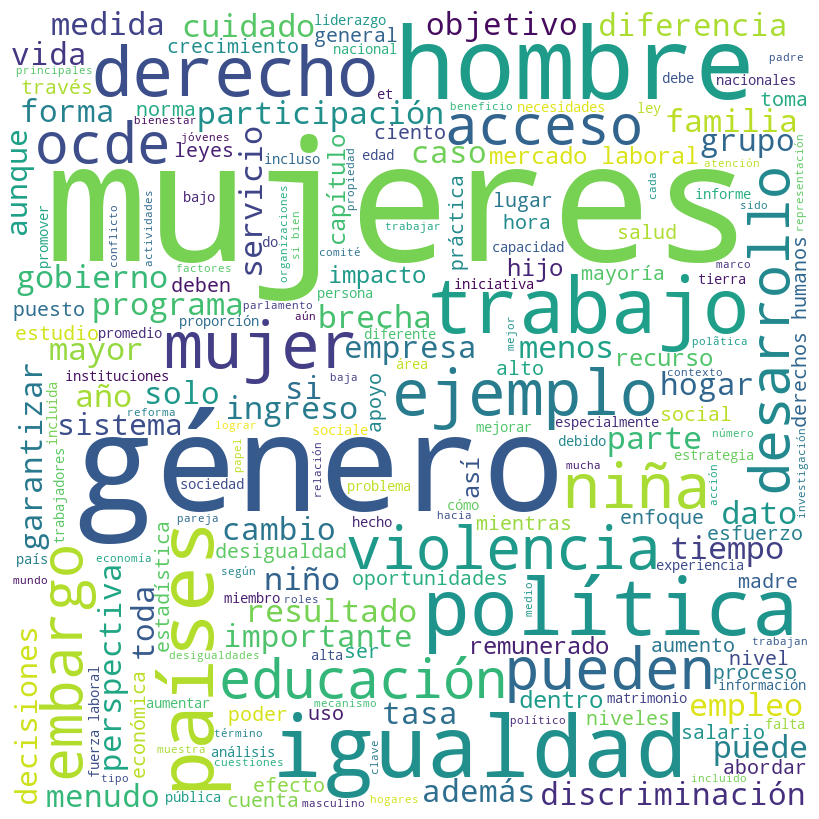

In [147]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['sdg'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['sdg']==i,'Textos_espanol'], stopwords=stop_words)

In [148]:
train

,Textos_espanol,sdg
0,"Por ejemplo, el número de consultas externas d...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


# Preparación de los datos

In [149]:
X_train, y_train = train['Textos_espanol'], train['sdg'] 
display(X_train)
y_train

0       Por ejemplo, el número de consultas externas d...
1       En 2007, el gobierno central financió directam...
2       Claramente, hay muchos otros factores en juego...
3       Por ejemplo, el estado australiano de Victoria...
4       El consumo anual de alcohol se estima en 15,7 ...
                              ...                        
4044    Para ello, identificará las cuestiones de géne...
4045    La participación de las mujeres en roles de li...
4046    Según el WEF, según las tendencias de 2016, po...
4047    Sirve como recurso y foro para las agencias, c...
4048    Las áreas útiles para un mayor estudio y acció...
Name: Textos_espanol, Length: 4049, dtype: object

0       3
1       3
2       3
3       3
4       3
       ..
4044    5
4045    5
4046    5
4047    5
4048    5
Name: sdg, Length: 4049, dtype: int64

In [150]:
def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lower(words: list[str]):
    return [word.lower() for word in words]

def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]

def remove_numbers(words):
    new_words = []
    for word in words:
        if not word.isdigit(): 
            new_words.append(word)  
    return new_words

def preprocessing(words):
    #words = remove_non_ascii(words)
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = remove_numbers(words)
    return words

In [151]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0    [ejemplo, número, consultas, externas, especia...
1    [gobierno, central, financió, directamente, so...
2    [claramente, factores, juego, particular, vari...
3    [ejemplo, australiano, victoria, creó, agencia...
4    [consumo, anual, alcohol, estima, litros, año,...
Name: Textos_espanol, dtype: object

In [152]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0    [ejempl, numer, consult, extern, especial, cad...
1    [gobiern, central, financ, direct, sol, gast, ...
2    [clar, factor, jueg, particul, vary, barrer, d...
3    [ejempl, australian, victori, cre, agenci, pro...
4    [consum, anual, alcohol, estim, litr, año, hom...
Name: Textos_espanol, dtype: object

In [153]:
def concatenar (words):
    return ' '.join(words)

new_X_train = new_X_train.apply(concatenar)
new_X_train.head()

0    ejempl numer consult extern especial cad mil d...
1    gobiern central financ direct sol gast total s...
2    clar factor jueg particul vary barrer determin...
3    ejempl australian victori cre agenci promocion...
4    consum anual alcohol estim litr año hombr enci...
Name: Textos_espanol, dtype: object

In [154]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(new_X_train)

print(X_tfidf.shape)
X_tfidf

(4049, 9523)


<4049x9523 sparse matrix of type '<class 'numpy.float64'>'
	with 182900 stored elements in Compressed Sparse Row format>

# Entrenar un modelo KNN

In [155]:
X = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
X.head()
X_train = X
X_train

,04s,10º,12m,12º,14ª,15ª,17ccem,17ª,1991b,1992a,...,zon,zonmw,zuck,zukowski,zupanc,zusatzentgelt,ãfric,ãndic,ãrab,être
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4046,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
X_train.isnull().sum()

04s              0
10º              0
12m              0
12º              0
14ª              0
                ..
zusatzentgelt    0
ãfric            0
ãndic            0
ãrab             0
être             0
Length: 9523, dtype: int64

In [157]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create the desicion tree with KNN
from sklearn.neighbors import KNeighborsClassifier

best_n = 1
best_accuracy = 0
act_accuracy = 0

for i in range(1, 500):
    if i % 25 == 0:
        print(f"Actualmente probando con {i} neighbors")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train2, y_train2)
    y_pred = knn.predict(X_test2)
    act_accuracy = accuracy_score(y_test2, y_pred)
    if act_accuracy > best_accuracy:
        best_accuracy = act_accuracy
        best_n = i

print(f'Best accuracy: {best_accuracy} with n_neighbors: {best_n}')

Actualmente probando con 25 neighbors
Actualmente probando con 50 neighbors
Actualmente probando con 75 neighbors
Actualmente probando con 100 neighbors
Actualmente probando con 125 neighbors
Actualmente probando con 150 neighbors
Actualmente probando con 175 neighbors
Actualmente probando con 200 neighbors
Actualmente probando con 225 neighbors
Actualmente probando con 250 neighbors
Actualmente probando con 275 neighbors
Actualmente probando con 300 neighbors
Actualmente probando con 325 neighbors
Actualmente probando con 350 neighbors
Actualmente probando con 375 neighbors
Actualmente probando con 400 neighbors
Actualmente probando con 425 neighbors
Actualmente probando con 450 neighbors
Actualmente probando con 475 neighbors
Best accuracy: 0.9728395061728395 with n_neighbors: 43


In [158]:
knn = KNeighborsClassifier(n_neighbors=best_n)
knn.fit(X_train2, y_train2)
y_pred = knn.predict(X_test2)

In [159]:
# Calculate the accuracy
print(accuracy_score(y_test2, y_pred))

print(classification_report(y_test2, y_pred))

0.9728395061728395
              precision    recall  f1-score   support

           3       1.00      0.96      0.98       250
           4       0.95      0.98      0.97       268
           5       0.97      0.97      0.97       292

    accuracy                           0.97       810
   macro avg       0.97      0.97      0.97       810
weighted avg       0.97      0.97      0.97       810



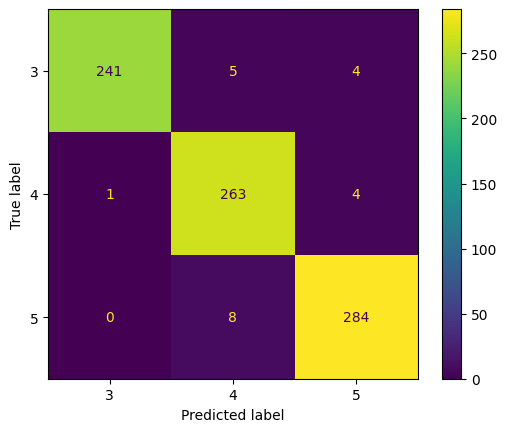

In [160]:
cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()

# Realización del Pipeline